# Assignment 3

This notebook is the solution to HW3, written by Yaniv Bin and Tair Hakman.

We first would like to import all the required modules in order for our code to run properly:

In [25]:
import nltk
import matplotlib.pyplot as plt
import numpy as np
from nltk import nonterminals, Nonterminal, Production
from nltk import CFG
from nltk import PCFG
from nltk.parse import generate
import itertools
from nltk.grammar import Nonterminal
from nltk.grammar import toy_pcfg2
from nltk.probability import DictionaryProbDist
from nltk import Tree
from nltk.grammar import Production
from nltk import induce_pcfg
from numpy import log
from nltk.corpus import LazyCorpusLoader, BracketParseCorpusReader
from nltk.grammar import Production
from nltk import Tree, Nonterminal
from collections import *

Now after doing so we can go ahead and solve the tasks.

## Part 1

In the first part of the assignment we will discuss designing CFG for NLP task.
<br> We were given the following code which read CFGs from string representation, and parse sentences given a CFG using a  a bottom-up parsing algorithm:

In [5]:
sg = """
S -> NP VP
VP -> IV | TV NP
NP -> 'John' | "bread"
IV -> 'left'
TV -> 'eats'
"""
g = CFG.fromstring(sg)

# Bottom-up  parser
sr_parser = nltk.ShiftReduceParser(g, trace=2)

# Parse sentences and observe the behavior of the parser
def parse_sentence(sent):
    tokens = sent.split()
    trees = sr_parser.parse(tokens)
    for tree in trees:
        print(tree)

parse_sentence("John left")
parse_sentence("John eats bread")

Parsing 'John left'
    [ * John left]
  S [ 'John' * left]
  R [ NP * left]
  S [ NP 'left' * ]
  R [ NP IV * ]
  R [ NP VP * ]
  R [ S * ]
(S (NP John) (VP (IV left)))
Parsing 'John eats bread'
    [ * John eats bread]
  S [ 'John' * eats bread]
  R [ NP * eats bread]
  S [ NP 'eats' * bread]
  R [ NP TV * bread]
  S [ NP TV 'bread' * ]
  R [ NP TV NP * ]
  R [ NP VP * ]
  R [ S * ]
(S (NP John) (VP (TV eats) (NP bread)))


### Part 1.1

First, an important note about our parser, the Shift-Reduce parser. This parser does not support ambiguity at all. If multiple reductions are available for a single word, it will simply choose the first reduction listed (and if it fails, it will not go back to try the second reduction). This means we can't have the same NT on the rhs of two different rules.

We're required to support a new list of sentences. In order to explain the process of creating the CFG, we would like to split the sentence list into three different lists (slightly altering the original sentence order). The first list:

John left
John eats bread
John loves Mary
She loves John
She loves them 
Everybody loves John
A boy loves Mary

And here's the grammar:

In [20]:
sg = """
S -> DET NP VP | NP VP | PR_NOM VP
NP -> 'John' | 'bread' | 'Mary' | 'boy'
IV -> 'left' 
VP -> IV | TV NP | TV PR_ACC
TV -> 'eats' | 'loves'
PR_NOM -> 'She' | 'Everybody'
PR_ACC -> 'them'
DET -> 'A'
"""

g = CFG.fromstring(sg)

# Bottom-up  parser
sr_parser = nltk.ShiftReduceParser(g, trace=2)

sentences = """John left
John eats bread
John loves Mary
She loves John
She loves them 
Everybody loves John
A boy loves Mary
"""

sentences = sentences.split("\n")

for i in range(2,7):
    parse_sentence(sentences[i])
    print("---------")

Parsing 'John loves Mary'
    [ * John loves Mary]
  S [ 'John' * loves Mary]
  R [ NP * loves Mary]
  S [ NP 'loves' * Mary]
  R [ NP TV * Mary]
  S [ NP TV 'Mary' * ]
  R [ NP TV NP * ]
  R [ NP VP * ]
  R [ S * ]
(S (NP John) (VP (TV loves) (NP Mary)))
---------
Parsing 'She loves John'
    [ * She loves John]
  S [ 'She' * loves John]
  R [ PR_NOM * loves John]
  S [ PR_NOM 'loves' * John]
  R [ PR_NOM TV * John]
  S [ PR_NOM TV 'John' * ]
  R [ PR_NOM TV NP * ]
  R [ PR_NOM VP * ]
  R [ S * ]
(S (PR_NOM She) (VP (TV loves) (NP John)))
---------
Parsing 'She loves them'
    [ * She loves them]
  S [ 'She' * loves them]
  R [ PR_NOM * loves them]
  S [ PR_NOM 'loves' * them]
  R [ PR_NOM TV * them]
  S [ PR_NOM TV 'them' * ]
  R [ PR_NOM TV PR_ACC * ]
  R [ PR_NOM VP * ]
  R [ S * ]
(S (PR_NOM She) (VP (TV loves) (PR_ACC them)))
---------
Parsing 'Everybody loves John'
    [ * Everybody loves John]
  S [ 'Everybody' * loves John]
  R [ PR_NOM * loves John]
  S [ PR_NOM 'loves' * Joh

This bit was relatively easy to deal with. We've introduced pronouns, who are split (so far) into two categories by their case: Nominative (He, she etc) and accusative (her, them) etc. Nominative pronouns appear in the beginning of sentences, accusative ones in the end. So we've added pronouns as an alternative to NPs in the appropriate places. We've also introduced the category of determiners (only "A" so far), which can start a sentence before a noun ("A book") - note that a determiner can't precede a pronoun ("A she" is not legal).

Our next sentences are a bit different:

They love Mary 
They love her

The difference is the use of 'love' instead of 'loves'. This is a different kind of verb that follows different speakers - "They love" and "He loves" are legal, but "They loves" and "He love" aren't. So we'll split our grammar into two categories - sentences of type 1 (without s), and type 2.

In English, the category 1 is I/we/you/they (in this case, they will all be followed by 'love'), and category 2 is he/she/it (all followed by 'loves'). This separation is somewhat similar to singular/plural, however it is not the same - note that "I" (singluar) is in the same category as "we" and "they" (plural), while "you" can refer to both singluar and plural. So for a lack of better name, we will refer to those categories as categories 1 and 2.

So here's our new grammar:


In [21]:
sg = """
S -> S1 | S2
S1 -> PR_NOM1 VP1
VP1 -> TV1 NP | TV1 PR_ACC
TV1 -> 'love'
PR_NOM1 -> 'They'

S2 -> DET NP VP2 | NP VP2 | PR_NOM2 VP2
VP2 -> IV | TV2 NP | TV2 PR_ACC
TV2 -> 'eats' | 'loves'
PR_NOM2 -> 'She' | 'Everybody'

NP -> 'John' | 'bread' | 'Mary' | 'boy'
IV -> 'left' 
PR_ACC -> 'them' | 'her'
DET -> 'A'
"""

g = CFG.fromstring(sg)

# Bottom-up  parser
sr_parser = nltk.ShiftReduceParser(g, trace=2)

sentences = """John left
John eats bread
John loves Mary
She loves John
She loves them 
Everybody loves John
A boy loves Mary
They love Mary 
They love her
"""

sentences = sentences.split("\n")

for i in range(7,9):
    parse_sentence(sentences[i])
    print("---------")

Parsing 'They love Mary'
    [ * They love Mary]
  S [ 'They' * love Mary]
  R [ PR_NOM1 * love Mary]
  S [ PR_NOM1 'love' * Mary]
  R [ PR_NOM1 TV1 * Mary]
  S [ PR_NOM1 TV1 'Mary' * ]
  R [ PR_NOM1 TV1 NP * ]
  R [ PR_NOM1 VP1 * ]
  R [ S1 * ]
  R [ S * ]
(S (S1 (PR_NOM1 They) (VP1 (TV1 love) (NP Mary))))
---------
Parsing 'They love her'
    [ * They love her]
  S [ 'They' * love her]
  R [ PR_NOM1 * love her]
  S [ PR_NOM1 'love' * her]
  R [ PR_NOM1 TV1 * her]
  S [ PR_NOM1 TV1 'her' * ]
  R [ PR_NOM1 TV1 PR_ACC * ]
  R [ PR_NOM1 VP1 * ]
  R [ S1 * ]
  R [ S * ]
(S (S1 (PR_NOM1 They) (VP1 (TV1 love) (PR_ACC her))))
---------


As you can see, we split most rules into types 1 and 2. Note that accusative pronounes aren't changed - the word "her" will be the same in both "I love her" and "she loves her".
Our last group of sentences is:

John gave Mary a heavy book
John gave it to Mary

This is when we encounter the limitations of the SRP. Looking at the first sentence, "John gave Mary" is already a legal sentence in our grammar (assuming the verb "gave" is added). So once we parse "John gave Mary", before the parser continues to the next word, those words will be reduced to "S". The best solution would be to use a better, less limited parser that supports ambiguity. But sticking with the SR parser, our solution will be a bit untidy - we will simply add a rule that adds the rest of the words after S.

In [29]:
sg = """
S -> S1 | S2 | S DET AD_NP | S PREP_NP
S1 -> PR_NOM1 VP1
VP1 -> TV1 NP | TV1 PR_ACC
TV1 -> 'love'
PR_NOM1 -> 'They'

S2 -> DET NP VP2 | NP VP2 | PR_NOM2 VP2 | 
VP2 -> IV2 | TV2 NP | TV2 PR_ACC
TV2 -> 'eats' | 'loves' | 'gave'
PR_NOM2 -> 'She' | 'Everybody'
IV2 -> 'left'

NP -> 'John' | 'bread' | 'Mary' | 'boy' | 'book'
AD_NP -> ADJ NP
PREP_NP -> PREP NP
PR_ACC -> 'them' | 'her' | 'it'
PREP -> "to"
DET -> 'A' | 'a'
ADJ -> 'heavy'
"""

g = CFG.fromstring(sg)

# Bottom-up  parser
sr_parser = nltk.ShiftReduceParser(g, trace=2)

Let's verify all 11 sentences are parsed correctly:

In [28]:
sentences = """John left
John eats bread
John loves Mary
She loves John
She loves them 
Everybody loves John
A boy loves Mary
They love Mary 
They love her
John gave Mary a heavy book
John gave it to Mary"""

'''
Number: singular / plural (e.g., he/they)
Gender: masculine / feminine / neutral (e.g., he/she/it)
Case: nominative / accusative (e.g., he/him)
'''

sentences = sentences.split("\n")

for i in range(11):
    parse_sentence(sentences[i])
    print ("---------")

Parsing 'John left'
    [ * John left]
  S [ 'John' * left]
  R [ NP * left]
  S [ NP 'left' * ]
  R [ NP IV2 * ]
  R [ NP VP2 * ]
  R [ S2 * ]
  R [ S * ]
(S (S2 (NP John) (VP2 (IV2 left))))
---------
Parsing 'John eats bread'
    [ * John eats bread]
  S [ 'John' * eats bread]
  R [ NP * eats bread]
  S [ NP 'eats' * bread]
  R [ NP TV2 * bread]
  S [ NP TV2 'bread' * ]
  R [ NP TV2 NP * ]
  R [ NP VP2 * ]
  R [ S2 * ]
  R [ S * ]
(S (S2 (NP John) (VP2 (TV2 eats) (NP bread))))
---------
Parsing 'John loves Mary'
    [ * John loves Mary]
  S [ 'John' * loves Mary]
  R [ NP * loves Mary]
  S [ NP 'loves' * Mary]
  R [ NP TV2 * Mary]
  S [ NP TV2 'Mary' * ]
  R [ NP TV2 NP * ]
  R [ NP VP2 * ]
  R [ S2 * ]
  R [ S * ]
(S (S2 (NP John) (VP2 (TV2 loves) (NP Mary))))
---------
Parsing 'She loves John'
    [ * She loves John]
  S [ 'She' * loves John]
  R [ PR_NOM2 * loves John]
  S [ PR_NOM2 'loves' * John]
  R [ PR_NOM2 TV2 * John]
  S [ PR_NOM2 TV2 'John' * ]
  R [ PR_NOM2 TV2 NP * ]
  R

As for gender: we didn't need to encode it, because gender doesn't make a grammatical difference in English. Most pronouns (I/we/you/they) are netural to gender. And he/she, the only pronouns who are specific to a gender, behave the same gramatically ("he loves her", "she loves her"). The same also goes for nouns who have a clear gender ("John loves her", "Mary loves her").

We'll note that our grammar isn't perfect, and it does overgenerate in certain cases. One weakness is the lack of separation between different nouns, even though certain nouns can't logically do certain actions. This allows us to parse illogical sentences, such as:

In [31]:
parse_sentence("bread gave book a heavy Mary")

Parsing 'bread gave book a heavy Mary'
    [ * bread gave book a heavy Mary]
  S [ 'bread' * gave book a heavy Mary]
  R [ NP * gave book a heavy Mary]
  S [ NP 'gave' * book a heavy Mary]
  R [ NP TV2 * book a heavy Mary]
  S [ NP TV2 'book' * a heavy Mary]
  R [ NP TV2 NP * a heavy Mary]
  R [ NP VP2 * a heavy Mary]
  R [ S2 * a heavy Mary]
  R [ S * a heavy Mary]
  S [ S 'a' * heavy Mary]
  R [ S DET * heavy Mary]
  S [ S DET 'heavy' * Mary]
  R [ S DET ADJ * Mary]
  S [ S DET ADJ 'Mary' * ]
  R [ S DET ADJ NP * ]
  R [ S DET AD_NP * ]
  R [ S * ]
(S
  (S (S2 (NP bread) (VP2 (TV2 gave) (NP book))))
  (DET a)
  (AD_NP (ADJ heavy) (NP Mary)))


Another weakness is the workaround we've added for the last sentences, which basically allows us to add certain combinations (such as DET ADJ NP) at the end of every sentence:

In [32]:
parse_sentence("John loves Mary a heavy book")

Parsing 'John loves Mary a heavy book'
    [ * John loves Mary a heavy book]
  S [ 'John' * loves Mary a heavy book]
  R [ NP * loves Mary a heavy book]
  S [ NP 'loves' * Mary a heavy book]
  R [ NP TV2 * Mary a heavy book]
  S [ NP TV2 'Mary' * a heavy book]
  R [ NP TV2 NP * a heavy book]
  R [ NP VP2 * a heavy book]
  R [ S2 * a heavy book]
  R [ S * a heavy book]
  S [ S 'a' * heavy book]
  R [ S DET * heavy book]
  S [ S DET 'heavy' * book]
  R [ S DET ADJ * book]
  S [ S DET ADJ 'book' * ]
  R [ S DET ADJ NP * ]
  R [ S DET AD_NP * ]
  R [ S * ]
(S
  (S (S2 (NP John) (VP2 (TV2 loves) (NP Mary))))
  (DET a)
  (AD_NP (ADJ heavy) (NP book)))


And since the role is recursive, we can add it as many times as we like:

In [34]:
parse_sentence("John loves Mary a heavy book a heavy book a heavy book a heavy book a heavy book a heavy book a heavy book")

Parsing 'John loves Mary a heavy book a heavy book a heavy book a heavy book a heavy book a heavy book a heavy book'
    [ * John loves Mary a heavy book a heavy book a heavy book a heavy book a heavy book a heavy book a heavy book]
  S [ 'John' * loves Mary a heavy book a heavy book a heavy book a heavy book a heavy book a heavy book a heavy book]
  R [ NP * loves Mary a heavy book a heavy book a heavy book a heavy book a heavy book a heavy book a heavy book]
  S [ NP 'loves' * Mary a heavy book a heavy book a heavy book a heavy book a heavy book a heavy book a heavy book]
  R [ NP TV2 * Mary a heavy book a heavy book a heavy book a heavy book a heavy book a heavy book a heavy book]
  S [ NP TV2 'Mary' * a heavy book a heavy book a heavy book a heavy book a heavy book a heavy book a heavy book]
  R [ NP TV2 NP * a heavy book a heavy book a heavy book a heavy book a heavy book a heavy book a heavy book]
  R [ NP VP2 * a heavy book a heavy book a heavy book a heavy book a heavy book a h

### Part 1.2


## Part 2

NLTK has a model called generate which is able to generate sentences given a CFG grammer. 
Our goal in this part is to create a generator for a PCFG instead of a CFG.

### Part 2.1

We will firstly start by writing our generator function, which, given a PCFG, return a tree representing the generation process:

In [179]:
# generates a tree from a PCFG grammer 
def pcfg_generate(grammar):
    start = grammar.start()
    return(pcfg_generate_root(grammar, start))
    
# generates a tree from a given root based on the PCFG grammer    
def pcfg_generate_root(grammar, root):
    #if it's not a terminal it means we have to generate from the probabilities
    if isinstance(root, Nonterminal):
        item_productions = grammar.productions(lhs=root)
        dict = {}
        for pr in item_productions: dict[pr.rhs()] = pr.prob()
        item_probDist = DictionaryProbDist(dict)
        prod = item_probDist.generate()
        if (len(prod) == 2):
            lh = prod[0]
            rh = prod[1]
            lh_tree = pcfg_generate_root(grammar, lh)
            rh_tree = pcfg_generate_root(grammar, rh)
            return Tree(root, [lh_tree, rh_tree])
        else:
            lh = prod[0]
            return Tree(root,[pcfg_generate_root(grammar, lh)])
           
    #if it's a terminal we can just return it
    else:
        return root

Now we can test our function with the *toy_pcfg2* grammer:

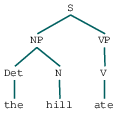

(S (NP (Det the) (N hill)) (VP (V ate)))
         S      
      ___|____   
     NP       VP
  ___|___     |  
Det      N    V 
 |       |    |  
the     hill ate



In [187]:
example_tree = pcfg_generate(toy_pcfg2)
import IPython
IPython.core.display.display(example_tree)
example_tree.pprint()
Tree.fromstring(example_tree.pformat()).pretty_print()

As we can see, not all the resulting sentences makes sense... 

We will now continue on to do some validations:

#### Part 2.1.1

The first thing we are going to do is to generate 1000 random trees given the *toy_pcfg2* grammer, and save all resulting trees into a file called "toy_pcfg2.gen"

In [195]:
def create_trees_file(n=1000):
    for i in range(n):
        current_tree = pcfg_generate(toy_pcfg2)
        with open("toy_pcfg2.gen", "a+") as f:
            current_tree.pprint(stream=f)
            f.write("*")

In [196]:
create_trees_file(n=1000)

#### Part 2.1.2

In [214]:
read_file = open("toy_pcfg2.gen", "r")
buffer = ""
for line in read_file :
    buffer += line
trees = buffer.split("*")
trees = trees[:len(trees) - 1]

In [265]:
toy_sample_productions = []
for tree in trees:
    toy_sample_productions += Tree.fromstring(tree).productions()

In [267]:
#One way of achieving our goal
pcfg_induced = induce_pcfg(Nonterminal('S'), toy_sample_productions).productions()

In [264]:
def calc_productions_probabilities(productions):
    #And another way
    cfd = nltk.ConditionalFreqDist((production.lhs(), production.rhs()) for production in productions)
    cpd_mle = nltk.ConditionalProbDist(cfd, nltk.MLEProbDist)
    return cpd_mle

In [270]:
toy_sample_probability = calc_productions_probabilities(toy_sample_productions)
print(toy_sample_probability.conditions())

[S, NP, Name, PP, P, Det, N, VP, V]


In [269]:
toy_pcfg_probability = calc_productions_probabilities(toy_pcfg2.productions())
print(toy_pcfg_probability.conditions())

[S, VP, NP, PP, V, N, Name, P, Det]


#### Part 2.1.3

In [296]:
def compute_kl_divergence(p, q, eps=0.0001):
    sp = list(p.samples())
    cp = len(sp)
    sq = list(q.samples())
    cq = len(sq)
    su = set(sp + sq)
    cu = len(su)
    pc = eps*((cq)/float(cp))
    qc = eps*((cp)/float(cq))
    kl = 0.0
    for i in su:
        if i in sp:
             p_i = p.prob(i) - pc
        else:
            p_i = eps
        if i in sq:
            q_i = q.prob(i) - qc
        else:
            q_i = eps
            
        kl +=  p_i * log( p_i / float(q_i))
    return kl

In [299]:
divergence = {}
for condition in toy_sample_probability.conditions():
    kl = compute_kl_divergence(toy_sample_probability[condition], toy_pcfg_probability[condition])
    divergence[condition] = kl
print(divergence)

{S: 0.0, NP: 0.016769055318143367, Name: 0.0033852302910155826, PP: 0.0, P: 0.021369753421888488, Det: 0.013761199547802194, N: 0.22508191881226158, VP: 0.3882076278950367, V: 0.06886553732824867}


#### Part 2.1.4

### Part 2.2

#### Part 2.2.1

In [381]:
def simplify_functional_tag(tag):
    if '-' in tag:
        tag = tag.split('-')[0]
    # -NONE- tag
    if "" == tag:
        return " "
    return tag


In [383]:
def get_tag(tree):
    if isinstance(tree, Tree):
        simplified_tag = simplify_functional_tag(tree.label())
        # -NONE- tag
        if simplified_tag == " ":
            return " "
        return Nonterminal(simplify_functional_tag(tree.label()))
    else:
        return tree

def tree_to_production(tree):
    # if the root is NONE we don't need to parse it more
    if(" " == get_tag(tree)):
        return
    else:
        return Production(get_tag(tree), [get_tag(child) for child in tree])

def tree_to_productions(tree):
    yield tree_to_production(tree)
    for child in tree:
        if isinstance(child, Tree):
            for prod in tree_to_productions(child):
                if prod:
                    yield prod

In [384]:
def pcfg_learn(treebank, n):
    trees = treebank.parsed_sents()[:n]
    trees_productions = []
    for tree in trees:
        productions = tree_to_productions(tree)
        trees_productions += [prod for prod in productions]
    pcfg_induced = induce_pcfg(Nonterminal('S'), trees_productions)
    return pcfg_induced


In [387]:
treebank = LazyCorpusLoader('treebank/combined', BracketParseCorpusReader, r'wsj_.*\.mrg')
two_hundred_trees_pcfg = pcfg_learn(treebank, 200)
four_hunred_trees_pcfg = pcfg_learn(treebank, 400)

In [ ]:
#TODO - answer part 1 questions

#### Part 2.2.2

Instead of doing what we did in the previous section , we don't want to build a pcfg now, just to watch the frequencies, so what we will do is build a freqDist

In [422]:
def pcfg_freq(treebank, n):
    trees = treebank.parsed_sents()[:n]
    trees_productions = []
    for tree in trees:
        productions = tree_to_productions(tree)
        trees_productions += [prod for prod in productions]
    pcfg_freq = Counter(trees_productions)
    return pcfg_freq

In [471]:
two_hundred_trees_freq = pcfg_freq(treebank, 200)

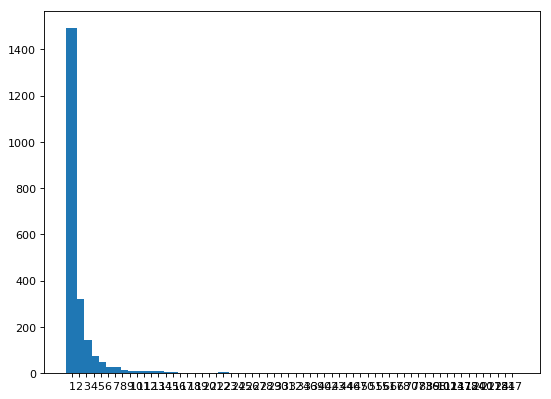

In [470]:
sorted_count = two_hundred_trees_freq.most_common()
_, counts = zip(*two_hundred_trees_freq.items())
counts = (list(counts))
counts.sort()

labels, values = zip(*Counter(counts).items())
indexes = np.arange(len(labels))


plt.figure(num=3, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.bar(indexes, values, 1.5)
plt.xticks(indexes, labels)
plt.show()